In [1]:
%matplotlib widget
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import pack_vis
import pack_dimer
import pack_vis_sol
import pack_cost
import numpy as np
import cupy as cp
import copy
kgs.set_float32(True)

local


In [2]:
%load_ext pyinstrument

In [3]:
#%%pyinstrument
import pack_io
importlib.reload(pack_io)
import pandas as pd
theirs = pack_io.dataframe_to_solution_list(pd.read_csv(kgs.code_dir + '../res/71.01.csv'))

In [4]:
# import matplotlib.pyplot as plt
# N_trees = np.arange(1,201)
# x1 = np.sqrt(N_trees)
# y1 = theirs[1]*N_trees / x1
# coeff1 = np.polyfit(x1, y1, 1)
# plt.figure()
# plt.plot(x1, y1, label='Scaled Score')
# plt.plot(x1, coeff1[0]*x1 + coeff1[1], '--', label=f'Linear fit: y={coeff1[0]:.3f}x+{coeff1[1]:.3f}')
# plt.legend()

# y2 = theirs[1]*N_trees
# coeff2 = np.polyfit(N_trees, y2, 1)
# plt.figure()
# plt.plot(N_trees, y2, label='Raw Score')
# plt.plot(N_trees, coeff2[0]*N_trees + coeff2[1], '--', label=f'Linear fit: y={coeff2[0]:.3f}x+{coeff2[1]:.3f}')
# plt.legend()

# plt.figure()
# x3 = 1/np.sqrt(N_trees)
# y3 = theirs[1]
# coeff3 = np.polyfit(x3[10:40], y3[10:40], 1)
# plt.plot(x3, y3, label='Inverse Sqrt Scaled Score')
# plt.plot(x3, coeff3[0]*x3 + coeff3[1], '--', label=f'Linear fit: y={coeff3[0]:.3f}x+{coeff3[1]:.3f}')
# plt.legend()
# 1/0.15**2

In [5]:
import glob
mine_list = [kgs.code_dir + '../res/tess_legalized.pickle'] + glob.glob(kgs.code_dir + '../res/ga_*.pickle')
print('remove all but tess later')
print(mine_list)
mine_list = [kgs.dill_load(x) for x in mine_list]

sols_controller = []
for N_trees in np.arange(1,201):
    try:
        fname = kgs.temp_dir + f'/controller_runs/done/ga_N{N_trees}_seed84_done.pickle'
        rr = kgs.dill_load(fname)
        sols_controller.append(rr.ga.champions[0].phenotype)
        #res_per_tree[N_trees].append([x[0] for x in rr.ga.best_costs_per_generation[-1]])
        #print(N_trees)
    except: pass
mine_list.append(sols_controller)
for m in mine_list:
    for s in m:
        s.xyt = s.xyt.astype(kgs.dtype_cp)
        s.h = s.h.astype(kgs.dtype_cp)
mine = []
for N_trees in np.arange(1,201):
    best_score = np.inf
    for m in mine_list:
        for s in m:
            if s.N_trees == N_trees:
                score = (s.h[0,0]**2/s.N_trees).get()
                if score < best_score:
                    best_score = score
                    best_sol = s
    mine.append(best_sol)
score = [(x.h[0,0]**2/x.N_trees).get() for x in mine]
mine = (mine,score)
kgs.dill_save(kgs.code_dir + '../res/mine.pickle', mine)

remove all but tess later
['/mnt/d//packing/code/core/../res/tess_legalized.pickle', '/mnt/d//packing/code/core/../res/ga_1to10.pickle', '/mnt/d//packing/code/core/../res/ga_36_to_36.pickle', '/mnt/d//packing/code/core/../res/ga_multi_tree_11_to_25.pickle', '/mnt/d//packing/code/core/../res/ga_multi_tree_11_to_25_cont.pickle', '/mnt/d//packing/code/core/../res/ga_multi_tree_26_to_29.pickle', '/mnt/d//packing/code/core/../res/ga_multi_tree_30_to_30.pickle', '/mnt/d//packing/code/core/../res/ga_multi_tree_40_to_40.pickle']


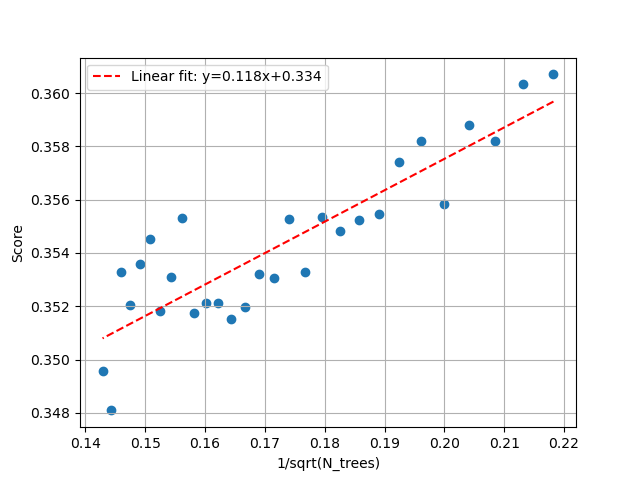

In [6]:
import mplcursors
import matplotlib.pyplot as plt

N_trees = np.arange(1,201)
plt.figure()
N1=20
N2=49
plt.scatter(1/np.sqrt(N_trees[N1:N2]), mine[1][N1:N2])
plt.grid(True)
plt.xlabel('1/sqrt(N_trees)')
plt.ylabel('Score')
# add a linear fit to the line; store the coefficients as well for later use
x_fit = 1/np.sqrt(N_trees[N1:N2])
y_fit = mine[1][N1:N2]
coeffs = np.polyfit(x_fit, y_fit, 1)
plt.plot(x_fit, coeffs[0]*x_fit + coeffs[1], '--r', label=f'Linear fit: y={coeffs[0]:.3f}x+{coeffs[1]:.3f}')
plt.legend()
prognosis = coeffs[0]/np.sqrt(N_trees) + coeffs[1]

(np.float64(71.01294293429139),
 np.float32(70.751335),
 np.float64(70.51100000388692),
 np.float64(70.13551773130298))

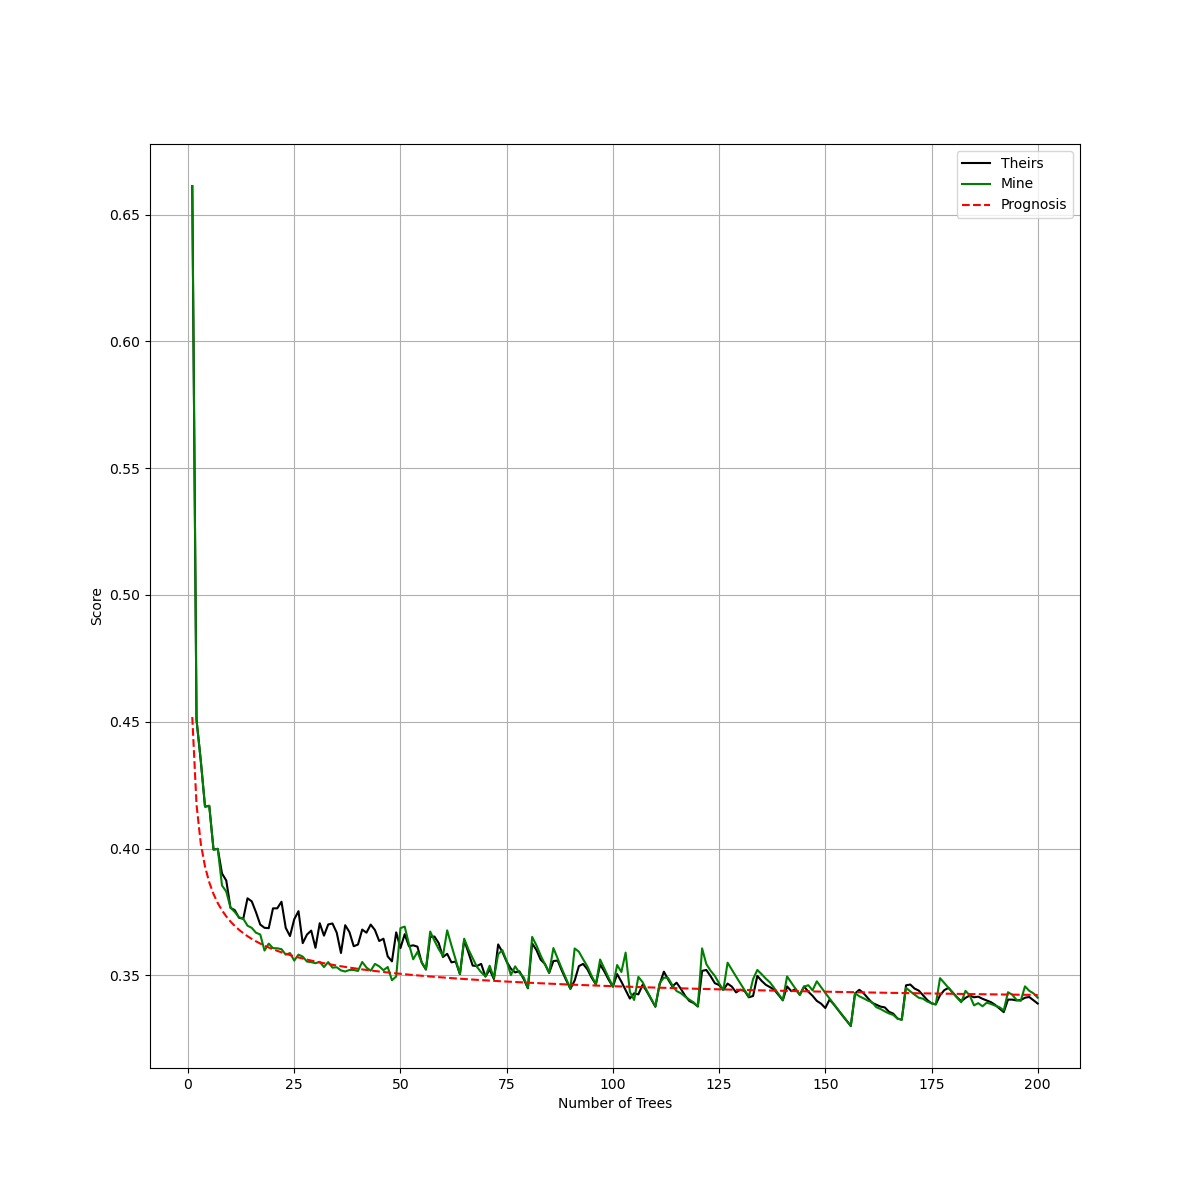

In [7]:
plt.figure(figsize=(12,12))
N=0
lines = []
vals_res = np.array([np.inf]*200)
line = plt.plot(N_trees[N:], theirs[1][N:], 'k')
lines.extend(line)
line = plt.plot(N_trees[N:], mine[1][N:], 'g')
lines.extend(line)
line = plt.plot(N_trees[N:], prognosis[N:], 'r--')
lines.extend(line)

plt.grid(True)
plt.legend(('Theirs', 'Mine', 'Prognosis'))
plt.xlabel('Number of Trees')
plt.ylabel('Score')

# Add interactive cursor for all lines
mplcursors.cursor(lines, hover=True)
NN=37
np.sum(theirs[1]), np.sum(mine[1]), np.sum(np.minimum(theirs[1], mine[1])), np.sum(mine[1][:NN]) + np.sum(np.minimum(mine[1][NN:], prognosis[NN:]))

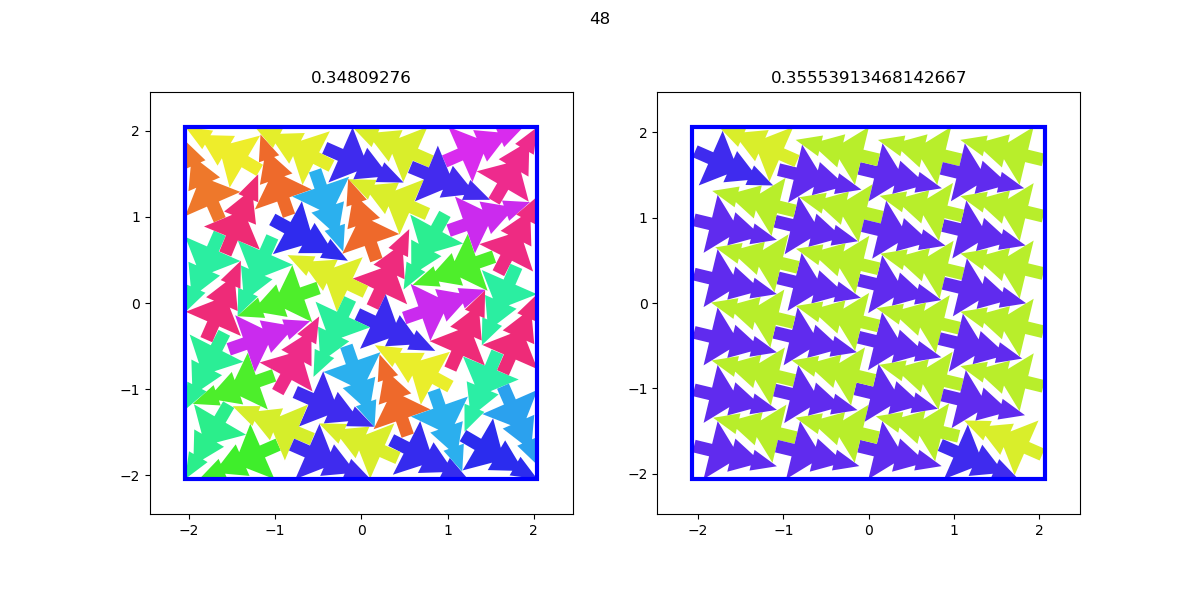

In [11]:
#importlib.reload(kgs)
for N in [48]:
    _,ax = plt.subplots(1,2,figsize=(12,6))
    pack_vis_sol.pack_vis_sol(mine[0][N-1], solution_idx=0, ax=ax[0])
    plt.sca(ax[0])
    plt.title(mine[1][N-1])
    sol2 = copy.deepcopy(theirs[0][N-1])
    sol2.xyt[0,...] = kgs.find_best_transformation(mine[0][N-1].xyt[0], sol2.xyt[0])[0]
    sol2.snap()
    #sol2.xyt = cp.concatenate((overall_best[N-1].xyt, sol2.xyt), axis=1)
    pack_vis_sol.pack_vis_sol(sol2, solution_idx=0, ax=ax[1])
    plt.sca(ax[1])
    plt.title(theirs[1][N-1])
    plt.suptitle(N)

In [12]:
import pack_io
pd = pack_io.solution_list_to_dataframe(mine[0], compact=False)
pd.to_csv(kgs.temp_dir + 'submission.csv', index=False)

Score of generated dataframe: 70.7507261817809


In [13]:
import pack_io
pd = pack_io.solution_list_to_dataframe(mine[0], compact=True)
pd.to_csv(kgs.temp_dir + 'submission_compact.csv', index=False)

Score of generated dataframe: 70.74904643934433
